In [1]:
import numpy as np
import constants as cnt
import matplotlib.pyplot as plt
import tools
import near0_integrated_analysis
import schottky_analysis as sch
from functools import lru_cache
from scipy.integrate import quad
from scipy.optimize import curve_fit


0.00014746639368170598 21.000000000000018
21.480000000000018


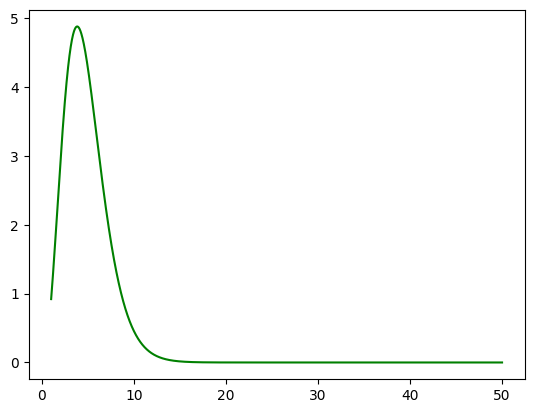

In [4]:
# test fonction intégrale

def fonction(x) :
    num = np.exp(x)*(x**4)
    denom = (np.exp(x) -1 )**2
    return num/denom

temp_test = np.arange(1, 50, 1e-2)

plt.figure()
plt.plot(temp_test, fonction(temp_test), "-g")

def zero(x, y, eps=1e-4) :
    i = 0
    for i in range(0, len(y)) :
        if y[i] < eps :
            return x[i]

print(fonction(temp_test)[2000], temp_test[2000])
print(zero(temp_test, fonction(temp_test)))

In [3]:
def integrand(t):
    # t scalar
    return t**4 * np.exp(t) / ((np.exp(t)-1)**2)

# Fonction pour I(y) avec mise en cache

@lru_cache(maxsize=1000)
def I_of_y_scalar(y):
   val, err = quad(integrand, 0, y)
   return val

def I(y_array) :
    result = []
    for yi in y_array :
        result.append(I_of_y_scalar(float(yi)))
    return result

y_test = np.arange(1, 400,1)

print(I(y_test))

[0.3172440452344265, 2.201088102433341, 5.964822397371477, 10.73193239299862, 15.35978431688218, 19.122976016053165, 21.821248922866914, 23.583979156921938, 24.65650393465895, 25.27366767703044, 25.61324225583976, 25.79334730171151, 25.885992976160253, 25.932431605893495, 25.955198214572256, 25.966147104202232, 25.97132485339212, 25.97373738268685, 25.9748467680487, 25.975350935212237, 25.975577640786717, 25.975678609099337, 25.975723187336634, 25.975742712990424, 25.975751203267095, 25.975754870391235, 25.975756444524418, 25.97575711636929, 25.975757401593484, 25.975757522084095, 25.9757575727497, 25.97575759396241, 25.97575760280786, 25.97575760648229, 25.975757608003207, 25.975757608630627, 25.97575760888862, 25.975757608994392, 25.975757609037636, 25.97575760905526, 25.975757609062438, 25.97575760906534, 25.975757609066523, 25.975757609067003, 25.975757609067198, 25.97575760906729, 25.97575760906734, 25.97575760906731, 25.975757609067315, 25.975757609067312, 25.975757609067315, 25.

/tmp/ipykernel_12205/1270378490.py:3: RuntimeWarning: overflow encountered in scalar power
  return t**4 * np.exp(t) / ((np.exp(t)-1)**2)


In [8]:
def integrand(t):
    # t scalar
    return t**4 * np.exp(t) / ((np.exp(t)-1)**2)

# Fonction pour I(y) avec mise en cache

@lru_cache(maxsize=1000)
def I_of_y_scalar(y):
   val, err = quad(integrand, 0, y)
   return val

def I(y_array) :
    result = []
    for yi in y_array :
        result.append(I_of_y_scalar(float(yi)))
    return result

def model(x, theta, gamma):
    """
    Modèle f(x) = gamma + x * I(theta / x)
    x: array-like positif
    theta, gamma: scalaires
    """
    x_arr = np.asarray(x, dtype=float)
    y_arr = theta / np.sqrt(x_arr)
    I_vals = I(y_arr)
    return gamma + x_arr * I_vals* 9e3*cnt.k*cnt.N/(theta**3)

def fit_data(xdata, ydata, p0=None, bounds=None):
    """
    Ajuste les données (xdata, ydata) au modèle, retourne (popt, pcov).
    - xdata, ydata: array-like de même longueur.
    - p0: liste ou tuple [theta0, gamma0] d'initialisation. Par défaut [1.0, np.mean(ydata)].
    - bounds: bornes pour θ et γ : ([theta_min, gamma_min], [theta_max, gamma_max]). Par défaut aucun.

    Exemple d'utilisation :
        popt, pcov = fit_data(xdata, ydata, p0=[2.0, 0.5], bounds=([0, -np.inf], [np.inf, np.inf]))
    """
    x_arr = np.asarray(xdata, dtype=float)
    y_arr = np.asarray(ydata, dtype=float)
    if x_arr.shape != y_arr.shape:
        raise ValueError("xdata and ydata must have same shape.")
    # Initial guess
    if p0 is None:
        theta0 = 1.0
        gamma0 = np.mean(y_arr)
        p0 = [theta0, gamma0]
    # Appel curve fit
    popt, pcov = curve_fit(model, x_arr, y_arr, p0=p0,
                           bounds=bounds or (-np.inf, np.inf))
    return popt, pcov

temperature_bounded, err_bounded = tools.tab_interval(cnt.temperature, cnt.err_C_divT, 0, 10)
squared_temperature_bounded, C_div_T_bounded = tools.tab_interval(cnt.squared_temperature, cnt.C_div_T, 0, 100)
y_data = C_div_T_bounded - sch.schottky(temperature_bounded, cnt.E_optic, cnt.n_optic)/temperature_bounded

print(fit_data(squared_temperature_bounded, y_data,p0=[300, 0], bounds= ([300, 0],[500, 10])))

(array([373.90340158,   1.68931363]), array([[0.24752191, 0.02795716],
       [0.02795716, 0.00562424]]))


(array([376.87514074,   2.7395018 ]), array([[0.28289906, 0.03095698],
       [0.03095698, 0.00603361]]))


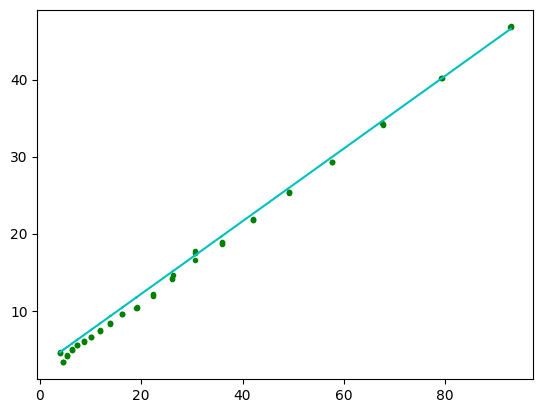

In [9]:
print(near0_integrated_analysis.fit_integrand_schottky_subtracted(0, 10, cnt.squared_temperature, cnt.temperature,
            cnt.C_div_T, cnt.E_curve_fit, cnt.n_curve_fit, p0=[300, 0], bounds=([300, 0], [500, 10])))

plt.figure()
plt.plot(squared_temperature_bounded, y_data, ".g")
plt.plot(squared_temperature_bounded, 
         near0_integrated_analysis.model_integrated_schottky_substracted(squared_temperature_bounded, 376.87, 2.73), "c-")


In [12]:
print(near0_integrated_analysis.fit_integrand_schottky(0, 20, cnt.squared_temperature, cnt.C_div_T, p0=[300, 0, 9.7e-23, 1e-3], 
                                                       bounds=([300, 0, 9.7e-23, 1e-3], [500, 10, 1.2e-22, 5e-2])))

(array([3.48469217e+02, 3.66930991e-22, 9.70000000e-23, 1.02965113e-02]), array([[ 1.16732944e-94,  0.00000000e+00, -1.03679768e-70,
         6.26506499e-91],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.03679768e-70,  0.00000000e+00,  9.20862096e-47,
        -5.56450017e-67],
       [ 6.26506499e-91,  0.00000000e+00, -5.56450017e-67,
         3.36246461e-87]]))
